# Análisis de detección cuando hay produccion

Se extraen archivos con videos de la bandeja de enfriamiento en dos momentos:
- Con produccion
- Sin produccion

Estos archivos estan en formato CSV con en dos carpetas diferentes

El algoritmo que genera estos archivos detecta como 0 aquel pixel de la imagen que no tiene movimiento, y como 1 aquel que si tiene movimiento.

Estas cantidades sumarizadas nos da una cantindad de movimiento por frame.

Lo que se analiza entonces es cuanto movimiento hay en un video con y sin produccion de PVC.

In [5]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#Listo el contenido de las carpetas que contienen los archivos

#Carpeta con archivos con produccion activa
folder_prod = os.listdir("../con blur/Con produccion")

#Carpeta con archivos sin produccion
folder_sin_prod = os.listdir("../con blur/Sin produccion")


In [6]:
"""
-Armo una lista que va a contener todos los archivos que estan en la carpeta de produccion en formato pandas DataFrame
-Luego otra lista donde va a contener el nombre de los archivos a medida que se van guardando en la lista anterior
"""

df_list = []
df_names = []
for file in folder_prod:

    bd=sqlContext.read.format("com.databricks.spark.csv").option("header","false").load(
    "file:/home/luca/Desktop/Tecnocom/csvs/con blur/Con produccion/"+str(file))
    
    df_prod = bd.toPandas().transpose().reset_index()
    df_prod = df_prod.drop(columns="index")
    df_names.append(file)
    df_list.append(df_prod)
 

In [7]:
"""
- Armo una lista que va a contener todos los archivos que estan en la carpeta sin produccion en formato pandas DataFrame
- Luego otra lista donde va a contener el nombre de los archivos a medida que se van guardando en la lista anterior
"""

#Files sin Produccion
df_list_np = []
df_names_np = []
for file1 in folder_sin_prod:

    bd1=sqlContext.read.format("com.databricks.spark.csv").option("header","false").load(
    "file:/home/luca/Desktop/Tecnocom/csvs/con blur/Sin produccion/"+str(file1))
    
    df_np = bd1.toPandas().transpose().reset_index()
    df_np = df_np.drop(columns="index")
    df_names_np.append(file1)
    df_list_np.append(df_np)


#### Graficamos los valores de los videos

De esta forma podemos detectar algun patron que diferencie entre los videos cuando hay y cuando no hay produccion de PVC en la bandeja.

EL objetivo es encontrar un umbral de valores para diferenciar estos dos momentos de produccion.

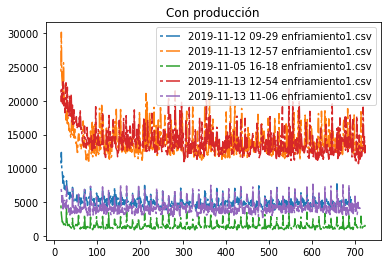

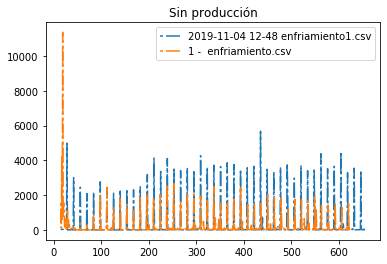

In [58]:
"""
Grafico que muestra en eje X el N° de Frame y en eje Y la cantidad de movimiento detectado para los archivos en produccion
Se quitan de este grafico los primeros 15 frames ya que es el tiempo que toma para estabilizarse el video
"""

fig, ax = plt.subplots()
i = 0

for df in df_list:

    x = df.index.values[15:].astype(int)
    y = df[0].values[15:].astype(float)

    line1 = ax.plot(x , y, dashes=[2, 2, 10, 2], label=df_names[i])
    #line1.set_dashes([2, 2, 10, 2])
    i += 1
    
ax.legend()
plt.title("Con producción")
plt.show()


"""
Grafico que muestra en eje X el N° de Frame y en eje Y la cantidad de movimiento detectado para los archivos sin pruduccion
Se quitan de este grafico los primeros 15 frames ya que es el tiempo que toma para estabilizarse el video
"""

fig, ax = plt.subplots()
i = 0
for df in df_list_np:

    x = df.index.values[15:].astype(int)
    y = df[0].values[15:].astype(float)

    line1 = ax.plot(x , y, dashes=[2, 2, 10, 2], label=df_names_np[i])
    #line1.set_dashes([2, 2, 10, 2])
    i += 1
    
ax.legend()
plt.title("Sin producción")
plt.show()

### Análisis de valores

Se toman los archivos con y sin produccion de PVC y obtenemos los valores mas representativos para detectar algun patrón
Los valores son:
- Cantidad
- Promedio
- Desviación Standard
- Valor minimo
- Valor Máximo
- Cuartiles

Luego de este análisis se puede observar una marcada diferencia en los valores mínimos de los dos momentos de producción

In [17]:
#Archivos sin producción

i = 0
print("Archivos sin producción")
for file in df_list_np:
    print(df_names_np[i],file.astype(float).describe())
    i += 1
    
i = 0    
print("\n Archivos con producción")
for file in df_list:
    print(df_names[i],file.astype(float).describe())
    i += 1
    


Archivos sin producción
2019-11-04 12-48 enfriamiento1.csv                   0
count    656.000000
mean     423.204268
std     3671.784682
min        0.000000
25%        7.000000
50%       12.000000
75%       20.000000
max    90041.000000
1 -  enfriamiento.csv                   0
count    627.000000
mean     445.081340
std     3924.808726
min        0.000000
25%        9.000000
50%       17.000000
75%       53.000000
max    90041.000000

 Archivos con producción
2019-11-12 09-29 enfriamiento1.csv                   0
count    695.000000
mean    5519.001439
std     4109.983199
min     3751.000000
25%     4588.500000
50%     4973.000000
75%     5478.000000
max    90041.000000
2019-11-13 12-57 enfriamiento1.csv                   0
count    723.000000
mean   14376.502075
std     4405.441806
min    11070.000000
25%    12597.500000
50%    13393.000000
75%    14748.000000
max    90041.000000
2019-11-05 16-18 enfriamiento1.csv                   0
count    725.000000
mean    1689.313103
std     

### Análisis Frame por Frame

Se realiza el mismo análisis que se ralizo por archivo, pero ahora se hace cada 5 segundos de video.
5 segundos de video equivale a 75 frames. Cada esta cantidad se extraen los siguientes valores para detectar patrones:

- Cantidad
- Promedio
- Desviación Standard
- Valor minimo
- Valor Máximo
- Cuartiles

Luego de este análisis se puede observar que cuando no hay producción los valores minimos nunca supera el valor 10 y cuando hay produccion el valor siempre supera los 3000

De esta forma podemos establecer un umbral de diferenciacion entre los dos momentos de produccion.

- Produccion: Minimos mayores a 1000
- Sin produccion: Minimos menores a 1000

In [43]:
#Archivos con produccion

i = 0
lista = []
total_prod = []
for file in df_list[:2]:
    
    for data in file.values:
        lista.append(data)
        
        if i % 75 == 0:
            lista = pd.DataFrame(lista).astype(int)
            total_prod.append(lista.min())
            print(lista.describe())
            lista = []
        i += 1
            

             0
count      1.0
mean   90041.0
std        NaN
min    90041.0
25%    90041.0
50%    90041.0
75%    90041.0
max    90041.0
                  0
count     75.000000
mean    8557.960000
std     6853.267393
min     4022.000000
25%     5588.000000
50%     6325.000000
75%     8724.500000
max    51031.000000
                 0
count    75.000000
mean   5388.546667
std     653.542680
min    4207.000000
25%    4940.500000
50%    5390.000000
75%    5775.500000
max    7388.000000
                 0
count    75.000000
mean   5162.200000
std     671.576021
min    3870.000000
25%    4674.500000
50%    5107.000000
75%    5469.000000
max    7492.000000
                 0
count    75.000000
mean   4817.293333
std     599.092033
min    3764.000000
25%    4430.000000
50%    4761.000000
75%    5018.000000
max    7095.000000
                 0
count    75.000000
mean   4841.120000
std     564.060519
min    3751.000000
25%    4503.000000
50%    4762.000000
75%    4964.000000
max    6684.000000
 

In [44]:
#Archivos sin produccion

i = 0
j = 0
lista = []
total_np = []
for file in df_list_np:
    
    for data in file.values:
        lista.append(data)
            
        if i % 75 == 0:
            lista = pd.DataFrame(lista).astype(int)
            total_np.append(lista.min())
            print(df_names_np[j])
            print(lista.describe())
            
            lista = []
        i += 1
    j += 1

2019-11-04 12-48 enfriamiento1.csv
             0
count      1.0
mean   90041.0
std        NaN
min    90041.0
25%    90041.0
50%    90041.0
75%    90041.0
max    90041.0
2019-11-04 12-48 enfriamiento1.csv
                  0
count     75.000000
mean     436.746667
std     2051.161557
min        0.000000
25%        4.000000
50%       11.000000
75%       48.500000
max    16749.000000
2019-11-04 12-48 enfriamiento1.csv
                 0
count    75.000000
mean    159.306667
std     582.889980
min       0.000000
25%       3.000000
50%       5.000000
75%       7.000000
max    2766.000000
2019-11-04 12-48 enfriamiento1.csv
                 0
count    75.000000
mean    273.373333
std     860.813832
min       0.000000
25%       4.000000
50%       6.000000
75%      10.500000
max    4135.000000
2019-11-04 12-48 enfriamiento1.csv
                 0
count    75.000000
mean    259.133333
std     903.766717
min       4.000000
25%      10.000000
50%      13.000000
75%      21.500000
max    4108.0000

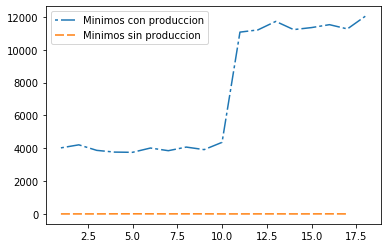

In [45]:
#Grafico los minimos de los dos momentos para visualizar sus valores
#Tenemos menos datos de cuando

df_total_prod = pd.DataFrame(total_prod)
df_total_np = pd.DataFrame(total_np)

fig, ax = plt.subplots()

x = df_total_prod.index.values[1:].astype(int)
y = df_total_prod[0].values[1:].astype(float)

line1 = ax.plot(x , y, dashes=[2, 2, 10, 2], label="Minimos con produccion")


x = df_total_np.index.values[1:].astype(int)
y = df_total_np[0].values[1:].astype(float)

line2 = ax.plot(x, y, dashes=[6, 2], label="Minimos sin produccion")

ax.legend()
plt.show()

In [51]:
print("Valores minimos con produccion cada 5 seg de video: \n ",df_total_prod[0].values[1:].astype(int),"\n")

print("Valores minimos sin produccion cada 5 seg de video: \n ",df_total_np[0].values[1:].astype(int),"\n")



Valores minimos con produccion cada 5 seg de video: 
  [ 4022  4207  3870  3764  3751  4012  3850  4070  3915  4358 11070 11204
 11723 11223 11347 11524 11265 12037] 

Valores minimos sin produccion cada 5 seg de video: 
  [0 0 0 4 5 4 2 4 3 0 0 1 2 0 1 3 0] 

